In [1]:
import os
import math
import theano
import seaborn
import itertools 
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation
from keras.regularizers import l2, activity_l2

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import cm
%matplotlib inline

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5004)
/Users/franciscojavierarceo/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


# Generating synthetic data from a step function in two variables

In [22]:
x1 = np.arange(-100,100)
x2 = np.arange(-100,100)
xs = np.asarray(list(itertools.product(x1,x2)))
ys = np.zeros( (len(xs),))

# This defines our function (i.e., f(x) = y)
clist = [-75, -50, -25, 25, 50, 75]
olist = [10, 25, 50, 75, 100]
for c, o in zip(clist, olist):
    flt = (xs[:,0]> c) & (xs[:,1] > c)
    ys[np.where(flt),] = o
    
# Splitting the training and test data
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.5, random_state=420)

## Slightly modified

In [15]:
x1 = np.arange(-100,100)
x2 = np.arange(-100,100)
xs = np.asarray(list(itertools.product(x1,x2)))
ys = np.zeros( (len(xs),))

# This defines our function (i.e., f(x) = y)
clist = [-75, -50, -25, 25, 50, 75]
olist = [10, 25, 50, 75, 100]
for c, o in zip(clist, olist):
    ys[np.where(xs[:,0]> c),] = o
    ys[np.where(xs[:,1]> c-10),] = o -10
    
# Splitting the training and test data
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.5, random_state=420)

## Still modified function

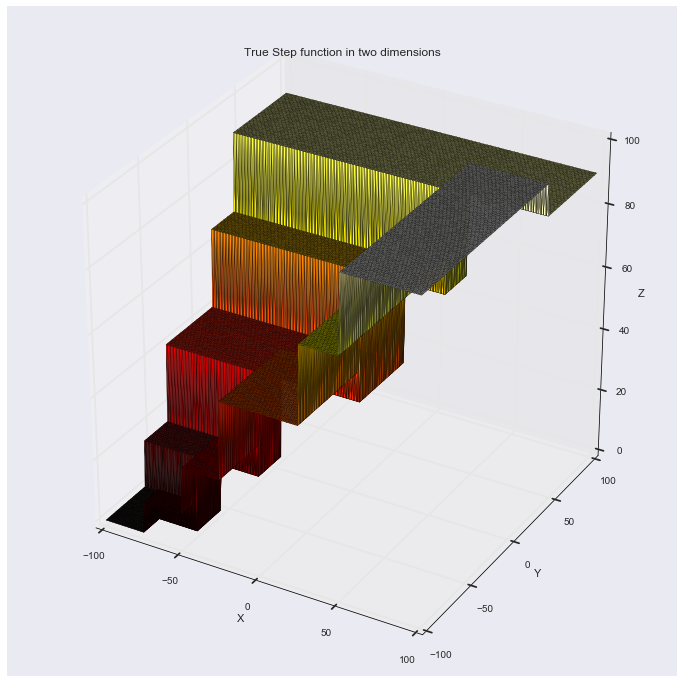

In [16]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(xs[:,0], xs[:,1], ys, cmap=cm.hot)
ax.set_title('True Step function in two dimensions')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Plotting the true step function

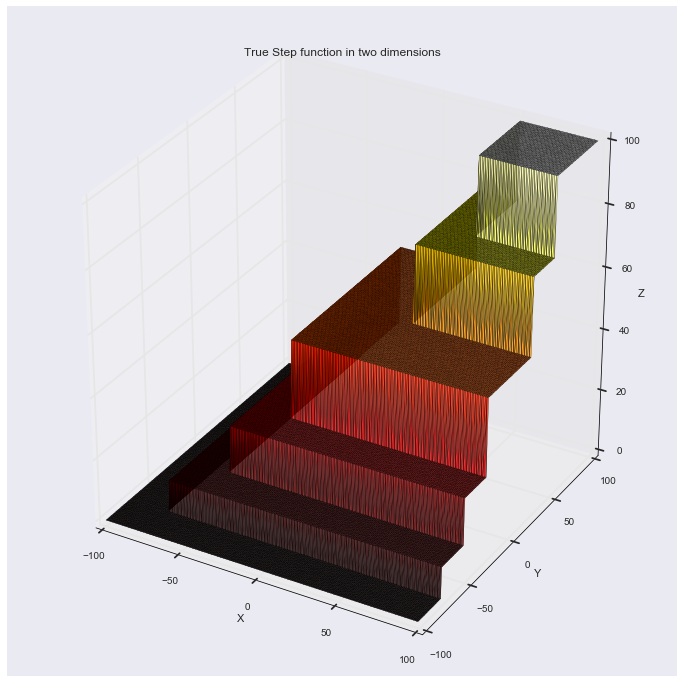

In [33]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(xs[:,0], xs[:,1], ys, cmap=cm.hot, alpha=0.8)
ax.set_title('True Step function in two dimensions')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Learning a GBM

In [15]:
estimator = GradientBoostingRegressor(n_estimators=1000, 
                                      random_state=420, 
                                      verbose=False,
                                      learning_rate=0.2)
estimator.fit(X_train, y_train)
yprd_tst = estimator.predict(X_test)
err = yprd_tst - y_test

# Learning the NN

In [16]:
nhidden = 10
n_neurons = 200
model = Sequential()

# Initial layer
model.add(Dense(n_neurons, input_dim=2, activation='relu'))

# Creating nhidden number of layers 
for i in range(nhidden):
    model.add(Dense(n_neurons, activation='relu', W_regularizer=l2(0.01),
                    activity_regularizer=activity_l2(0.01)))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train, y_train,
          nb_epoch=200, batch_size=50,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping])

yprd_tstnn = model.predict(X_test)[:,0]
errnn = yprd_tstnn - y_test

Train on 20000 samples, validate on 20000 samples
Epoch 1/200
20000/20000 [==============================] - 13s - loss: 297.0490 - val_loss: 66.0970
Epoch 2/200
20000/20000 [==============================] - 12s - loss: 102.5588 - val_loss: 51.1929
Epoch 3/200
20000/20000 [==============================] - 13s - loss: 69.5571 - val_loss: 38.5236
Epoch 4/200
20000/20000 [==============================] - 11s - loss: 58.7280 - val_loss: 26.7805
Epoch 5/200
20000/20000 [==============================] - 8s - loss: 54.6934 - val_loss: 32.8791
Epoch 6/200
20000/20000 [==============================] - 8s - loss: 48.0388 - val_loss: 26.3663
Epoch 7/200
20000/20000 [==============================] - 8s - loss: 46.2440 - val_loss: 23.0976
Epoch 8/200
20000/20000 [==============================] - 8s - loss: 42.1680 - val_loss: 17.7608
Epoch 9/200
20000/20000 [==============================] - 8s - loss: 40.8158 - val_loss: 25.5667
Epoch 10/200
20000/20000 [==============================] - 8s

/Users/franciscojavierarceo/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:489: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


# Plotting the learned function and the residuals in 3d


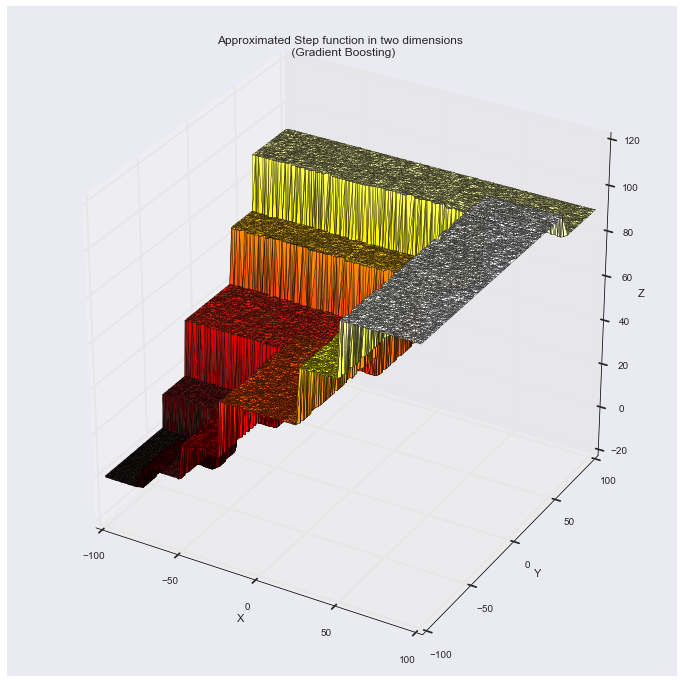

In [17]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X_test[:,0], X_test[:,1], yprd_tst, cmap=cm.hot)
ax.set_title('Approximated Step function in two dimensions \n (Gradient Boosting)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [18]:
rmse_gbm = np.sqrt( ((yprd_tst - y_test)**2).sum())
rmse_nns = np.sqrt( ((yprd_tstnn - y_test)**2).sum())

print("The RMSE of the GBM is %0.3f" % rmse_gbm)
print("The RMSE of the NN is %0.3f" % rmse_nns)

print("The GBM/NN RMSE = %0.3f" % (rmse_gbm / rmse_nns) )

The RMSE of the GBM is 17.274
The RMSE of the NN is 477.470
The GBM/NN RMSE = 0.036


In [38]:
import matplotlib
matplotlib.use('QT4Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

class MyAxes3D(axes3d.Axes3D):

    def __init__(self, baseObject, sides_to_draw):
        self.__class__ = type(baseObject.__class__.__name__,
                              (self.__class__, baseObject.__class__),
                              {})
        self.__dict__ = baseObject.__dict__
        self.sides_to_draw = list(sides_to_draw)
        self.mouse_init()

    def set_some_features_visibility(self, visible):
        for t in self.w_zaxis.get_ticklines() + self.w_zaxis.get_ticklabels():
            t.set_visible(visible)
        self.w_zaxis.line.set_visible(visible)
        self.w_zaxis.pane.set_visible(visible)
        self.w_zaxis.label.set_visible(visible)

    def draw(self, renderer):
        # set visibility of some features False 
        self.set_some_features_visibility(False)
        # draw the axes
        super(MyAxes3D, self).draw(renderer)
        # set visibility of some features True. 
        # This could be adapted to set your features to desired visibility, 
        # e.g. storing the previous values and restoring the values
        self.set_some_features_visibility(True)

        zaxis = self.zaxis
        draw_grid_old = zaxis.axes._draw_grid
        # disable draw grid
        zaxis.axes._draw_grid = False

        tmp_planes = zaxis._PLANES

        if 'l' in self.sides_to_draw :
            # draw zaxis on the left side
            zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                             tmp_planes[0], tmp_planes[1],
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)
        if 'r' in self.sides_to_draw :
            # draw zaxis on the right side
            zaxis._PLANES = (tmp_planes[3], tmp_planes[2], 
                             tmp_planes[1], tmp_planes[0], 
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)

        zaxis._PLANES = tmp_planes

        # disable draw grid
        zaxis.axes._draw_grid = draw_grid_old

def example_surface(ax):
    """ draw an example surface. code borrowed from http://matplotlib.org/examples/mplot3d/surface3d_demo.html """
    from matplotlib import cm
    import numpy as np
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    Z = np.sin(R)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

def create_surface(ax):
    """ draw an example surface. code borrowed from http://matplotlib.org/examples/mplot3d/surface3d_demo.html """
    from matplotlib import cm
    import numpy as np
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    Z = np.sin(R)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

def show_3_surfaceplots():
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(131, projection='3d')
    ax.set_title('z-axis left side')
    
    ax = fig.add_axes(MyAxes3D(ax, 'l'))
    example_surface(ax) # draw an example surface
    
    ax = fig.add_subplot(132, projection='3d')
    ax.set_title('z-axis both sides')
    ax = fig.add_axes(MyAxes3D(ax, 'lr'))
    
    example_surface(ax) # draw an example surface
    ax = fig.add_subplot(133, projection='3d')
    ax.set_title('z-axis right side')
    ax = fig.add_axes(MyAxes3D(ax, 'r'))
    example_surface(ax) # draw an example surface
    plt.show()

/Users/franciscojavierarceo/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


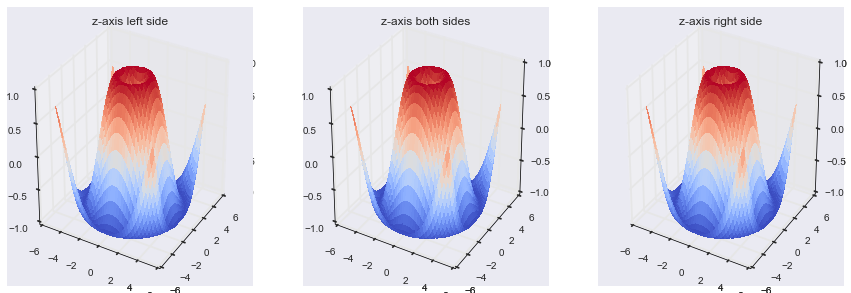

In [41]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection='3d')
ax.set_title('z-axis left side')
ax = fig.add_axes(MyAxes3D(ax, 'l'))
example_surface(ax) # draw an example surface
ax = fig.add_subplot(132, projection='3d')
ax.set_title('z-axis both sides')
ax = fig.add_axes(MyAxes3D(ax, 'lr'))
example_surface(ax) # draw an example surface
ax = fig.add_subplot(133, projection='3d')
ax.set_title('z-axis right side')
ax = fig.add_axes(MyAxes3D(ax, 'r'))
example_surface(ax) # draw an example surface
plt.show()

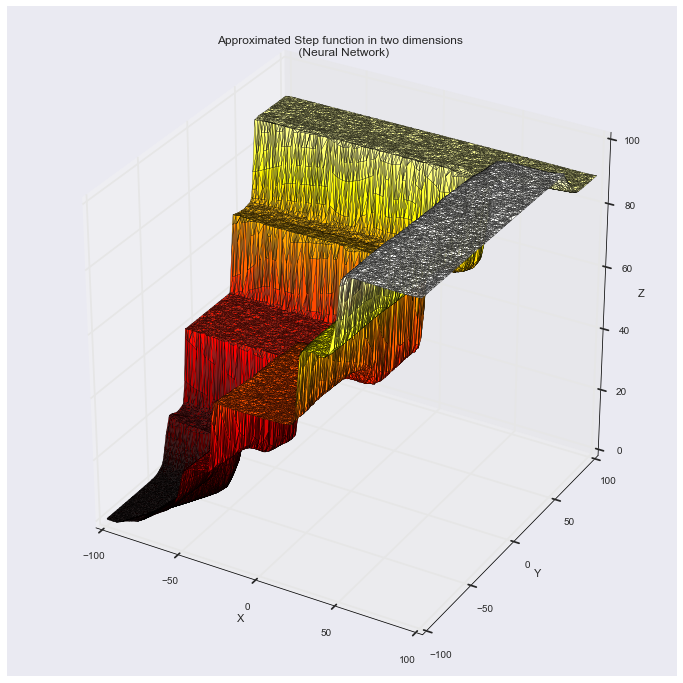

In [37]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d', )
ax.plot_trisurf(X_test[:,0], X_test[:,1], yprd_tstnn, cmap=cm.hot)
ax.set_title('Approximated Step function in two dimensions \n (Neural Network)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

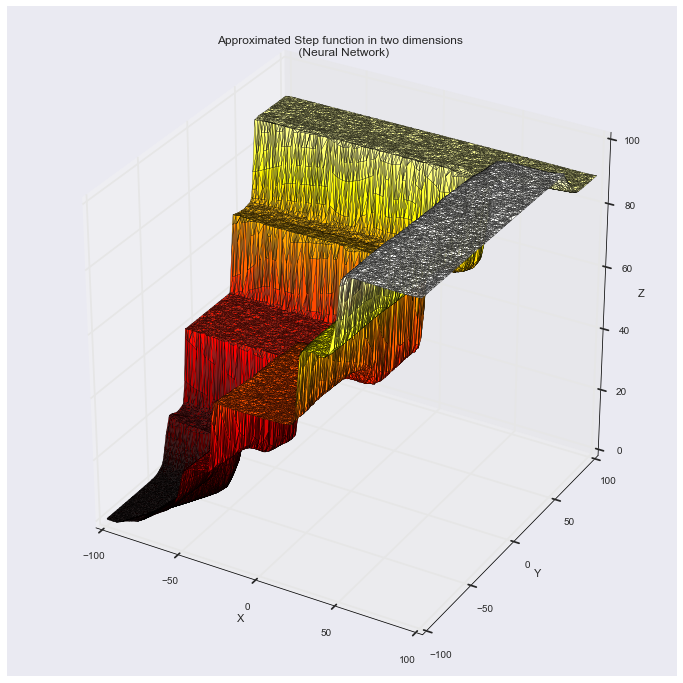

In [19]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X_test[:,0], X_test[:,1], yprd_tstnn, cmap=cm.hot)
ax.set_title('Approximated Step function in two dimensions \n (Neural Network)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

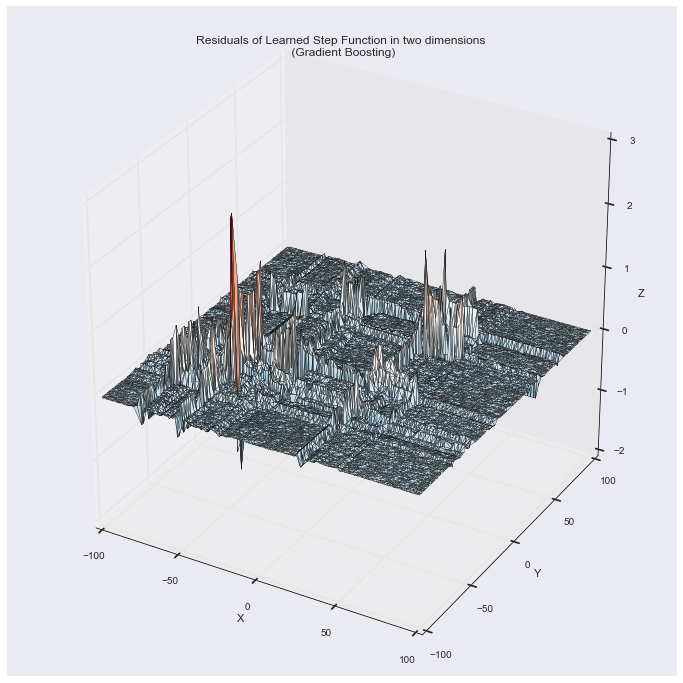

In [20]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X_test[:,0], X_test[:,1], err, cmap=cm.RdBu_r)
ax.set_title('Residuals of Learned Step Function in two dimensions \n (Gradient Boosting)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

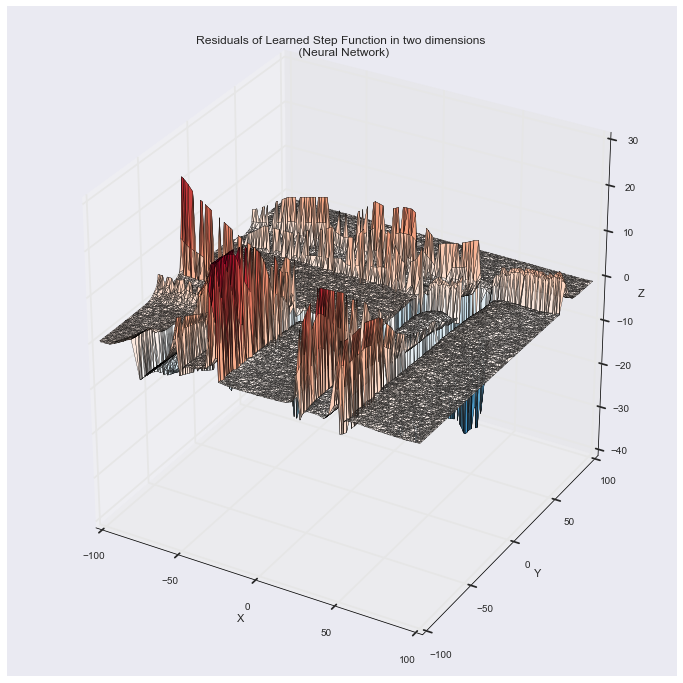

In [21]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X_test[:,0], X_test[:,1], errnn, cmap=cm.RdBu_r)
ax.set_title('Residuals of Learned Step Function in two dimensions \n (Neural Network)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

-----
# Generating a 1-d Step Function

In [95]:
xs = np.arange(-100,100, 0.01).reshape((20000))
ys = np.zeros( (len(xs)))

# This defines our function (i.e., f(x) = y)
clist = [-75, -50, -25, 25, 50, 75]
olist = [10, 25, 50, 75, 100]

for c, o in zip(clist, olist):
    ys[np.where(xs> c),] = o
    
X_train, X_test, y_train, y_test = train_test_split(xs.reshape((len(xs),1)), 
                                                    ys.reshape((len(ys),)), 
                                                    test_size=0.5, 
                                                    random_state=420)

# Learning GBM

In [97]:
estimator = GradientBoostingRegressor(n_estimators=10000, 
                                      random_state=420, 
                                      verbose=False,
                                      learning_rate=0.1, 
                                      max_depth=2)

estimator.fit(X_train, y_train)
yprd_tst = estimator.predict(X_test)
err = yprd_tst - y_test

# Learning the NN

In [98]:
nhidden = 9
n_neurons = 200
model = Sequential()

# Initial layer
model.add(Dense(n_neurons, input_dim=1, activation='relu'))

# Creating nhidden number of layers 
for i in range(nhidden):
        model.add(Dense(n_neurons, W_regularizer=l2(0.01)))
        model.add(Activation('relu'))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train, y_train,
          nb_epoch=200, batch_size=50,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping],
         verbose=0)

yprd_tstnn = model.predict(X_test)[:,0]
errnn = yprd_tstnn - y_test

In [99]:
rmse_gbm = np.sqrt( ((yprd_tst - y_test)**2).sum())
rmse_nns = np.sqrt( ((yprd_tstnn - y_test)**2).sum())

print("The RMSE of the GBM is %0.3f" % rmse_gbm)
print("The RMSE of the NN is %0.3f" % rmse_nns)

print("The GBM/NN RMSE = %0.3f" % (rmse_gbm / rmse_nns) )

The RMSE of the GBM is 38.405
The RMSE of the NN is 197.790
The GBM/NN RMSE = 0.194


In [102]:
def makePlots(xtest, ytest, gbm_pred, nn_pred, gbm_err, nn_err):
    plt.figure(figsize=(16,18))
    plt.subplot(3, 1, 1)
    plt.scatter(xtest, ytest)
    plt.title('True X vs Y')
    plt.xlabel('Input')
    plt.ylabel('Output')

    plt.subplot(3, 2, 3)
    plt.scatter(xtest, gbm_pred)
    plt.title("GBM")
    plt.xlabel('Input')
    plt.ylabel('Output')

    plt.subplot(3, 2, 4)
    plt.scatter(xtest, nn_pred)
    plt.title("NN")
    plt.xlabel('Input')
    plt.ylabel('Output')

    plt.subplot(3, 2, 5)
    plt.scatter(xtest, gbm_err, c='red')
    plt.title("GBM - Residuals")
    plt.xlabel('Input')
    plt.ylabel('Output')

    plt.subplot(3, 2, 6)
    plt.scatter(xtest, nn_err, c='red')
    plt.title("NN - Residuals")
    plt.xlabel('Input')
    plt.ylabel('Output')

    plt.show()

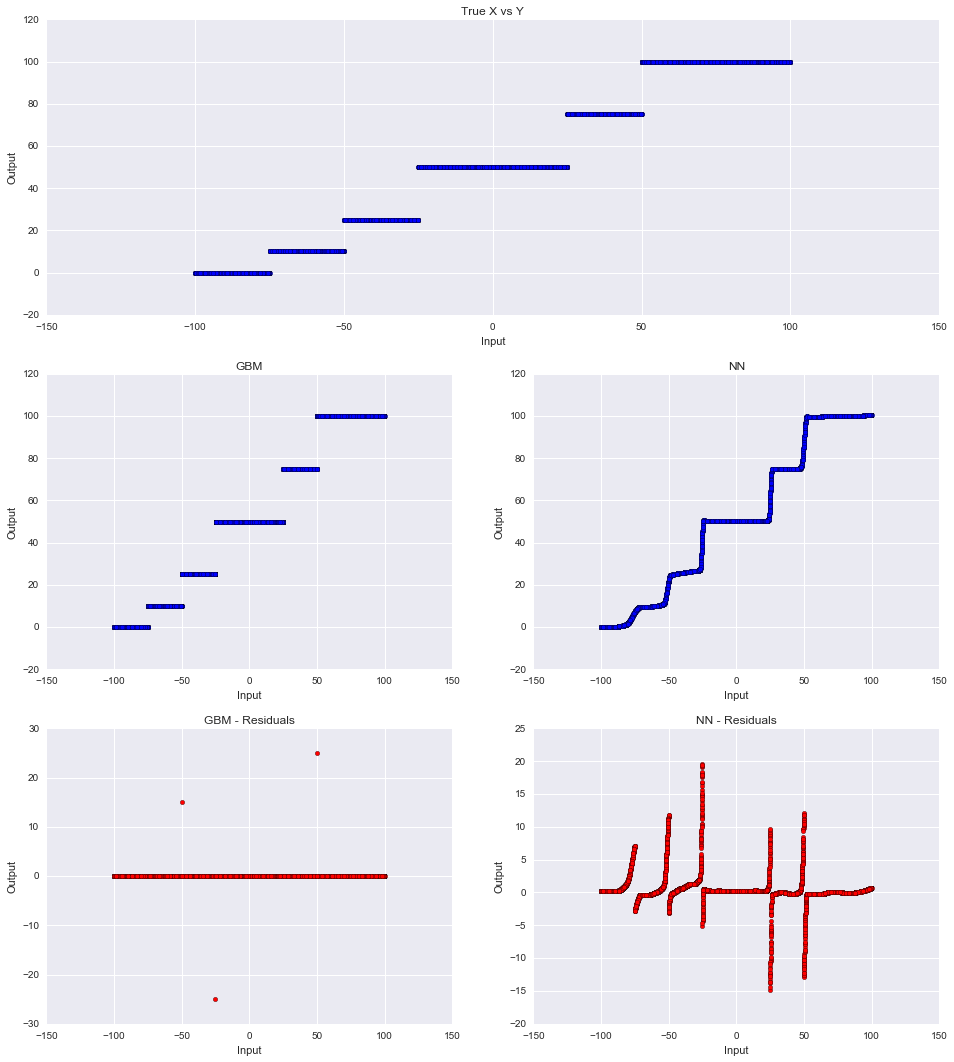

In [100]:
makePlots(X_test, y_test, yprd_tst, yprd_tstnn, err, errnn)

# Maxout layer

In [101]:
nhidden = 3
n_neurons = 100
model = Sequential()

# Initial layer
model.add(Dense(n_neurons, input_dim=1, activation='relu'))

# Creating nhidden number of layers 
for i in range(nhidden):
    model.add( keras.layers.core.MaxoutDense(n_neurons, nb_feature=10 )) 

model.add(Dense(1))
adam = keras.optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mse', optimizer=adam)


early_stopping = EarlyStopping(monitor='val_loss', patience=100)
model.fit(X_train, y_train,
          nb_epoch=1000, batch_size=50,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping],
          verbose=0)

yprd_tstnn = model.predict(X_test)[:,0]
errnn = yprd_tstnn - y_test

In [104]:
rmse_gbm = np.sqrt( ((yprd_tst - y_test)**2).sum())
rmse_nns = np.sqrt( ((yprd_tstnn - y_test)**2).sum())

print("The RMSE of the GBM is %0.3f" % rmse_gbm)
print("The RMSE of the NN is %0.3f" % rmse_nns)

print("The GBM/NN RMSE = %0.3f" % (rmse_gbm / rmse_nns) )

The RMSE of the GBM is 38.405
The RMSE of the NN is 153.493
The GBM/NN RMSE = 0.250


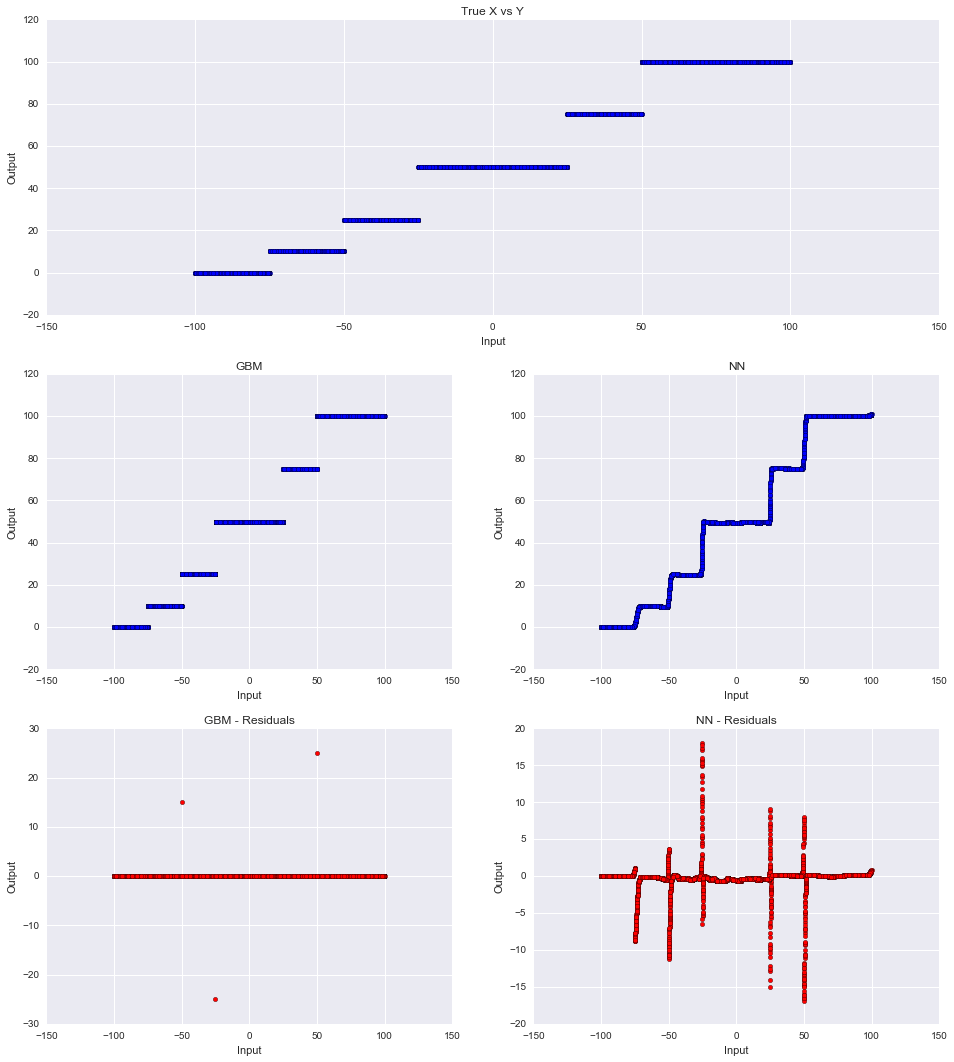

In [103]:
makePlots(X_test, y_test, yprd_tst, yprd_tstnn, err, errnn)

# Let's try something more simple -- implementing a binary activation layer

In [105]:
import theano.tensor as T
x = T.dscalar('x')
y = T.dscalar('y')
z_k = K.clip(x + y, 0 , 1)
z_t = T.clip(x + y, 0 , 1)
f_k = theano.function([x, y], z_k)
f_t = theano.function([x, y], z_t)

print('Theano clip')
print(f_t(2, 3))
print(f_t(-2, -3))

print('Keras clip')
print(f_k(2, 3))
print(f_k(-2, -3))

Theano clip
1.0
0.0
Keras clip
1.0
0.0


In [106]:
def binary_activation(x):
    return K.clip(x, 0,1)

In [107]:
xs = np.arange(-100,100).reshape((200))
ys = np.zeros( (len(xs)))

c = 0.
o = 25.

# This defines our function (i.e., f(x) = y)
ys[np.where(xs> c),] = o
    
X_train, X_test, y_train, y_test = train_test_split(xs.reshape((len(xs),1)), 
                                                    ys.reshape((len(ys),)), 
                                                    test_size=0.5, 
                                                    random_state=420)

# Learning the GBM

In [110]:
estimator = GradientBoostingRegressor(n_estimators=10000, 
                                      random_state=420, 
                                      verbose=False,
                                      learning_rate=0.1, 
                                      max_depth=2)

estimator.fit(X_train, y_train)
yprd_tst = estimator.predict(X_test)
err = yprd_tst - y_test

# Learning the NN

In [114]:
nhidden = 10
n_neurons = 200
model = Sequential()

# Initial layer
model.add(Dense(n_neurons, input_dim=1, activation='relu'))

# Creating nhidden number of layers 
for i in range(nhidden):
    if (i % 2)==0:
        model.add(Dense(n_neurons, W_regularizer=l2(0.01)))
        model.add(Activation('relu'))
        
    if (i % 2)==1:
        model.add(Dense(1, W_regularizer=l2(0.01)))
        model.add(Activation(binary_activation))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train, y_train,
          nb_epoch=200, batch_size=50,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping],
         verbose=0)

yprd_tstnn = model.predict(X_test)[:,0]
errnn = yprd_tstnn - y_test

In [117]:
rmse_gbm = np.sqrt( ((yprd_tst - y_test)**2).sum())
rmse_nns = np.sqrt( ((yprd_tstnn - y_test)**2).sum())

print("The RMSE of the GBM is %0.3f" % rmse_gbm)
print("The RMSE of the NN is %0.3f" % rmse_nns)

print("The GBM/NN RMSE = %0.3f" % (rmse_gbm / rmse_nns) )

The RMSE of the GBM is 0.003
The RMSE of the NN is 166.398
The GBM/NN RMSE = 0.000


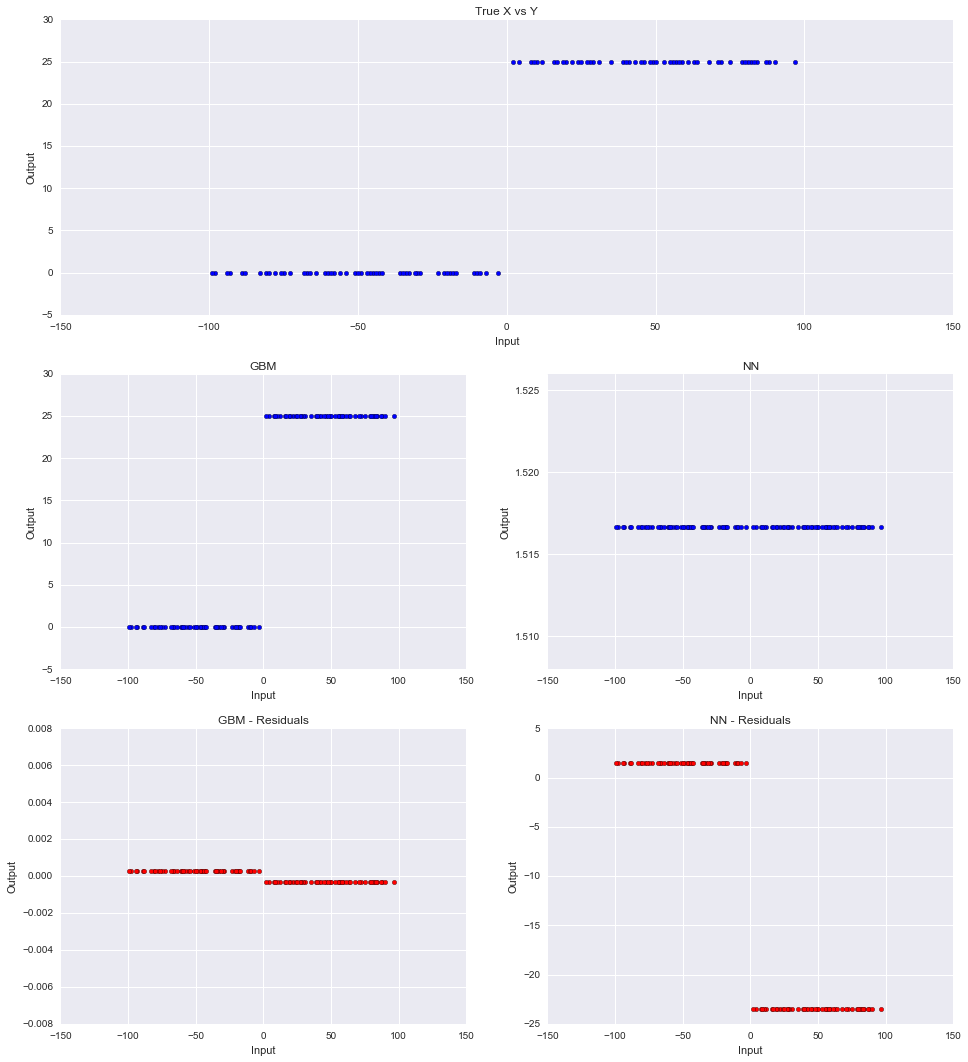

In [118]:
makePlots(X_test, y_test, yprd_tst, yprd_tstnn, err, errnn)